In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from  matplotlib import ticker
import seaborn as sns
import pickle

In [30]:
# ! pip install --user seaborn

    100% |████████████████████████████████| 215kB 2.0MB/s ta 0:00:01    88% |████████████████████████████▍   | 184kB 3.1MB/s eta 0:00:01


In [6]:
from faraday_rotation import Target
from faraday_rotation import Simulation
from faraday_rotation import Configuration
from faraday_rotation import Detection

# Introduction
This notebook can be used for testing various experimental setups in an x-ray polarimetry experiment using Faraday rotation.

In such an experiment a previously linearly polarized beam travels through an optically active sample.
Due to the circular birefringence of the material the original polarization changes after passing through the sample. 
The change in the polarization direction can than be obtained, by placing an analyzer in front of the detector and comparing with a reference measurement (no analyzer). This can be used to obtain information about the structure of the magnetic fields in a plasma (as soon as the electron density is already known), since the Faraday rotation effect in plasma depends on the magnetic field: 

$$ \phi = \frac{e_o}{2 c m_e}\int  \mathrm{d}x \ \frac{n_e}{n_c} \mathbf{B} \cdot \mathbf{\hat{k}} % Factor is missing$$ 

The rotation can be calculated, by integrating over the simulation output data, but this script uses an already calculated rotation. It can be provided as a text file or a numpy binary file (*.npy). 

# Settings
## Target:
At first some parameters regarding the simulation and the target (grid size, target position, target transmission) have to be set:

In [7]:
# target settings:
target_settings = {
    'x_s': 0,  # start position in x direction, in micron
    'x_e': 7.2,  # end position in x direction, in micron
    'y_s': -13.5,  # start in y direction, in micron
    'y_e': 13.5,  # end in y direction, in micron
    'trans': 0.72 #target transmission
}

In [8]:
# simulation settings:
simulation_settings = {
    'm': 1801,  # Nx: grid number in x direction
    'n': 6040,  # Ny: grid number if y direction, MUST be an even number
    'energy': 6.457  # Photon energy in keV of processed simulation file.
}

simulation = Simulation(Target(**target_settings), **simulation_settings)

## Experimental setup:
No some parameters of the synthetic experiment has to be chosen.
Further explanation for some of the variables:
- The analyzer position (`an_position`) is defined as its variation from the position providing the maximal extinction. That means, when `analyzer_position` is set to zero, the transmission axis is at an $\frac{\pi}{2}$ angle to the primary beam polarization direction. (See the graphic above.)

- Polarization impurity (`an_extinction`) is the percentage of the photons remaining polarized perpendicularly to the main polarization of the incoming beam.  
- 'det_beam_width' is the beam width at the detector. 
- Magnification (`m`) is the ratio of the target projection at the detector to the actual target size. Some exemplary values for different CLRs setups and targets:
<table>
	<tr>
    	<th>target type</th>
        <th>target position</th>
        <th>magnification</th>
    </tr>
</table> 


In [9]:
# optical setup:

#Transmission of all channelcuts including spectral bandwidth.
trans_channel = 0.43*0.6/0.8 

config_settings = {
    'an_position': -10, # analyzer position (mrad)
    'impurity': 1e-5,  # polarization impurity (1 = 100%)
    'an_extinction': 2e-7,  # analyzer extinction (1 = 100%)
    'det_obs_energy': 6.457, # observation energy in keV
    'det_trans_channel': trans_channel, # as above
    'det_pixel_size': 13,  # pixel size in micrometer (detector)
    'det_beam_width': 320,  # beam_width in micrometer
    'n_0': 1e12,  # initial number of photons
    'm': 30,  # magnification
    'trans_telescope': 1  # Transmission of CRLs due to beam size
        # mismatch (asymmetry).
}

config = Configuration(**config_settings)

In [10]:
## Loading simulation data. 
Simulation.load_data??

In [12]:
# load simulation data:
#path_to_file = '/home/pawel/Work/TEAM/fwt/members/hs5955/Faraday Rotation/MEC_Ti/Rotation_16.dat'
#simulation.load_data(path=path_to_file)

In [13]:
#np.save('sim', simulation.data)

In [15]:
simulation.data = np.load('sim.npy')

In [17]:
experiment = Detection(config, simulation)

In [18]:
experiment.calc_rotation()

In [19]:
experiment.calc_det_shape()

In [20]:
experiment.emulate_intensity()

/home/pawel/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [21]:
experiment.cfg.calc_ph_per_px_on_axis()

160000000.0

In [22]:
experiment.calc_beam_profile()

Displaying meany images with a common norm. (One colorbar, comparable; multiply some if the range is to wide)
Look here: https://matplotlib.org/gallery/images_contours_and_fields/multi_image.html 

In [23]:
experiment.ideal_detector = experiment.beam_profile*experiment.intensity_px

In [24]:
exp_with_noise = experiment.add_noise(accumulation=1)

In [25]:
exp_noise_acc = experiment.add_noise(accumulation = 30)

In [26]:
base_noise_acc = experiment.add_noise(accumulation=30, image=experiment.beam_profile)

In [27]:
rot = experiment.reobtain_rotation(exp_noise_acc, base_noise_acc)

Plots:

In [28]:
%matplotlib inline

In [29]:
# Importing cmaps:
# seaborn pckg is not on the server, so loading matplotlib cmap objects
# through pickle pckg. 
# cmaps has been generated elsewhere with seaborn. 
# notebook for genarating them included in the project path (generate_cmaps).

# path to cthe cmaps:
cmaps_path = 'mpl_cmaps/'

In [30]:
with open(cmaps_path + 'cmap_rotation_all_mpl.pkl', 'rb') as file:
     cmap_rotation_all = pickle.load(file)

In [31]:
with open(cmaps_path + 'cmap_rotation_extrema_mpl.pkl', 'rb') as file:
     cmap_rotation_extrema = pickle.load(file)

In [32]:
with open(cmaps_path + 'cmap_beam_profile_mpl.pkl', 'rb') as file:
     cmap_beam_profile = pickle.load(file)

In [33]:
def plot_rot(cmap, figsize, rotation, intensity_px, re_rot):
    rot_fig, axis = plt.subplots(1, 3, figsize=figsize)
    ax_rot_sim, ax_rot_sim_px, ax_rot_exp = axis

    ax_rot_sim.set_title('Simulated rotation')
    ax_rot_sim_px.set_title('Analyzer intensity profile')
    ax_rot_exp.set_title('Reobtained rotation')

    # Image boundaries, used for correct ticks labeling:
    edges = (experiment.sim.target.x_s, experiment.sim.target.x_e,
             experiment.sim.target.y_s, experiment.sim.target.y_e)
    
    v_min = min([np.min(rotation), np.min(re_rot)])
    v_max = max([np.max(rotation), np.max(re_rot)])
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
    
    ax_rot_sim.imshow(rotation, extent=edges, cmap=cmap, norm=norm)
    ax_rot_sim_px.imshow(intensity_px, extent=edges, cmap=cmap)
    ax_rot_exp.imshow(re_rot, extent=edges, cmap=cmap, norm=norm)
    
    c_bars = [None] * 3
    c_bars[0] = rot_fig.colorbar(axis[0].images[0], ax = axis[0])
    c_bars[1] = rot_fig.colorbar(axis[1].images[0], ax = axis[1], format=ticker.StrMethodFormatter('{x:.2e}'))
    c_bars[2] = rot_fig.colorbar(axis[2].images[0], ax = axis[2])

    c_bars[0].ax.set_title('[mrad]')
    #c_bars[1].ax.set_title('[mrad]')
    c_bars[2].ax.set_title('[mrad]')
    #c_bars[1].ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    
    for ax in axis:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto', prune=None))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto', prune=None))
    #for c_bar in c_bars:
     #   c_bar.ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto', prune=None))
    plt.tight_layout()  



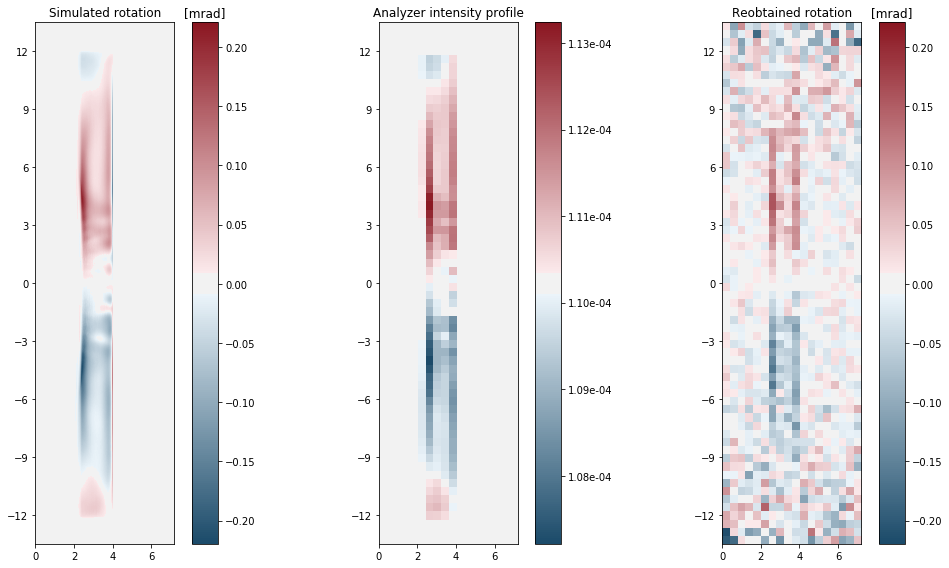

In [34]:
plot_rot(cmap_rotation_all, (15,8), experiment.rotation, experiment.intensity_px, rot)

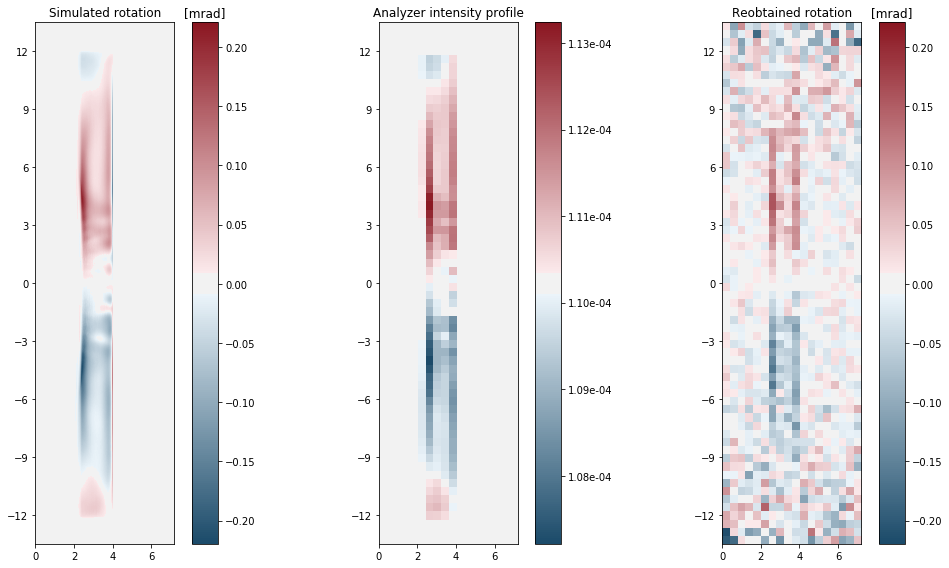

In [35]:
plot_rot(cmap_rotation_extrema, (15,8), experiment.rotation, experiment.intensity_px, rot)

In [36]:
def plot_det(cmap, figsize, base_noise_acc, exp_with_noise, exp_noise_acc):
    exp_fig, axis = plt.subplots(1, 3, figsize=figsize)
    ax_ref_acc, ax_ex_noise, ax_ex_acc = axis

    ax_ref_acc.set_title('Reference image, \n accumulated ... times.')
    ax_ex_noise.set_title('Signal with added noise.')
    ax_ex_acc.set_title('Accumulated noisy signal')
    # Image boundaries, used for correct ticks labeling:
    edges = (experiment.sim.target.x_s, experiment.sim.target.x_e,
             experiment.sim.target.y_s, experiment.sim.target.y_e)
    ax_ref_acc.imshow(base_noise_acc, extent=edges, cmap=cmap)
    ax_ex_noise.imshow(exp_with_noise, extent=edges, cmap=cmap)
    ax_ex_acc.imshow(exp_noise_acc, extent=edges, cmap=cmap)
    
    c_bars = [None] * 3
    for ax in axis:
        # Add colorbars:
        exp_fig.colorbar(ax.images[0], ax = ax, format = ticker.StrMethodFormatter('{x:.1e}'))
    plt.tight_layout()    

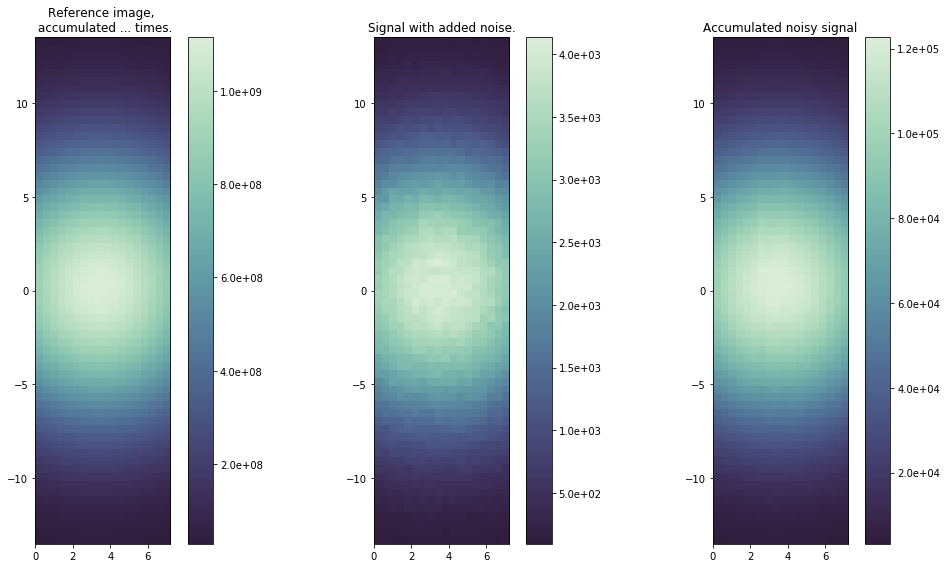

In [37]:
plot_det(cmap_beam_profile, (15,8), base_noise_acc, exp_with_noise, exp_noise_acc)